In [8]:
from torch.utils.data import Dataset, DataLoader# For custom data-sets
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import torch
import pandas as pd
from collections import namedtuple

n_class = 27

# a label and all meta information
Label = namedtuple( 'Label' , [
    'name'        , 
    'level3Id'    , 
    'color'       , 
    ] )

labels = [
    #       name                     level3Id  color
    Label(  'road'                 ,    0  , (128, 64,128)  ),
    Label(  'drivable fallback'    ,    1  , ( 81,  0, 81)  ),
    Label(  'sidewalk'             ,    2  , (244, 35,232)  ),
    Label(  'non-drivable fallback',    3  , (152,251,152)  ),
    Label(  'person/animal'        ,    4  , (220, 20, 60)  ),
    Label(  'rider'                ,    5  , (255,  0,  0)  ),
    Label(  'motorcycle'           ,    6  , (  0,  0,230)  ),
    Label(  'bicycle'              ,   7  , (119, 11, 32)  ),
    Label(  'autorickshaw'         ,   8  , (255, 204, 54) ),
    Label(  'car'                  ,   9  , (  0,  0,142)  ),
    Label(  'truck'                ,  10 ,  (  0,  0, 70)  ),
    Label(  'bus'                  ,  11 ,  (  0, 60,100)  ),
    Label(  'vehicle fallback'     ,  12 ,  (136, 143, 153)),  
    Label(  'curb'                 ,   13 ,  (220, 190, 40)),
    Label(  'wall'                 ,  14 ,  (102,102,156)  ),
    Label(  'fence'                ,  15 ,  (190,153,153)  ),
    Label(  'guard rail'           ,  16 ,  (180,165,180)  ),
    Label(  'billboard'            ,   17 ,  (174, 64, 67) ),
    Label(  'traffic sign'         ,  18 ,  (220,220,  0)  ),
    Label(  'traffic light'        ,  19 ,  (250,170, 30)  ),
    Label(  'pole'                 ,  20 ,  (153,153,153)  ),
    Label(  'obs-str-bar-fallback' , 21 ,  (169, 187, 214) ),  
    Label(  'building'             ,  22 ,  ( 70, 70, 70)  ),
    Label(  'bridge/tunnel'        ,  23 ,  (150,100,100)  ),
    Label(  'vegetation'           ,  24 ,  (107,142, 35)  ),
    Label(  'sky'                  ,  25 ,  ( 70,130,180)  ),
    Label(  'unlabeled'            ,  26 ,  (  0,  0,  0)  ),
]   

class IddDataset(Dataset):

    def __init__(self, csv_file, n_class=n_class, transforms_=None):
        self.data      = pd.read_csv(csv_file)
        self.n_class   = n_class
        self.mode = csv_file
        
        # Add any transformations here
        self.resize_transform = transforms.Resize((256, 256))
        # The following transformation normalizes each channel using the mean and std provided
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img = Image.open(img_name).convert('RGB')
        label_name = self.data.iloc[idx, 1]
        label = Image.open(label_name)
        #print("Img type is {}".format(type(img)))
        img = self.resize_transform(img)
        
        label = self.resize_transform(label)
        
        img = np.asarray(img) / 255. # scaling [0-255] values to [0-1]
        label = np.asarray(label)
        # Normalization
        img = self.transforms(img).float()
        # Convert to tensor
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.shape
        target = torch.zeros(self.n_class, h, w)
        for c in range(self.n_class):
            target[c][label == c] = 1
        
        return img, target, label


In [9]:
train_dataset = IddDataset(csv_file='train.csv')
val_dataset = IddDataset(csv_file='val.csv')
test_dataset = IddDataset(csv_file='test.csv')


train_loader = DataLoader(dataset=train_dataset, batch_size= 3, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= 3, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size= 3, num_workers=4, shuffle=False)

In [10]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

4018
2009
1004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> torch.Size([3, 256, 256])


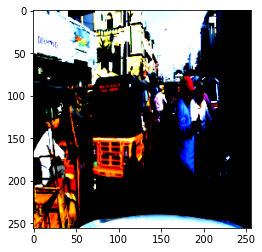

In [11]:
import matplotlib.pyplot as plt
# Print the shape of the training dataset
#print(train_dataset[0][0].shape)
# Permute the object into a different shape
train_image = train_dataset.__getitem__(0)
print(type(train_image[0]),train_image[0].shape)
tensor_image = train_image[0]
# print(type(tensor_image), tensor_image.shape)
plt.imshow(tensor_image.permute(1, 2, 0))
# plt.imshow(test_image.permute(1, 2, 0))
# plt.imshow(val_image.permute(1, 2, 0))

In [12]:
from torchvision import utils
from basic_fcn import *
#from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import pandas as pd 
from collections import defaultdict

# First read the dataset
train_dataset = IddDataset(csv_file='train.csv')
val_dataset = IddDataset(csv_file='val.csv')
test_dataset = IddDataset(csv_file='test.csv')

# train_loader, val_loader and test_loader are three different sets of data
train_loader = DataLoader(dataset=train_dataset, batch_size= 6, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= 6, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size= 6, num_workers=4, shuffle=False)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        #torch.nn.init.xavier_uniform(m.weight.data)
        torch.nn.init.xavier_uniform_(m.weight.data)
        #print("Dimension of weight = {}".format(m.weight.shape))
        #print("Dimension of bias = {}".format(m.bias.shape))
        #torch.nn.init.xavier_uniform(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
        
epochs = 100      
criterion = nn.CrossEntropyLoss()# Choose an appropriate loss function from https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html
fcn_model = FCN(n_class=n_class)
print("No of classes = ",n_class)
fcn_model.apply(init_weights)

optimizer = optim.Adam(fcn_model.parameters(), lr=5e-3)

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using GPU")
    fcn_model = fcn_model.cuda()

        
def train():
    print("Reached train function")
    best_loss = float('inf')
    val_loss = []
    train_loss = []
    for epoch in range(epochs):
        train_loss_batch = []
        ts = time.time()
        print("Epoch: {}".format(epoch))
        for itera, (X, tar, Y) in enumerate(train_loader):
            #print("Printing the contents of X, tar and Y")
            #print("X, tar, Y are {}, {} and {}".format(type(X), type(tar), type(Y)))
            optimizer.zero_grad()
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                #labels = tar.long()
                train_labels = Y.cuda()# Move your labels onto the gpu
            else:
                inputs, train_labels = X, Y#.long() # Unpack variables into inputs and labels

            outputs = fcn_model(inputs)
            loss = criterion(outputs, train_labels)
            loss = torch.unsqueeze(loss,0)
            loss = loss.mean()
            train_loss_batch.append(loss.item())
            loss.backward()
            optimizer.step()
            
            if itera % 100 == 0:
                print("TRAINING: epoch{}, iter{}, loss: {}".format(epoch, itera, loss.item())) 
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        train_loss.append(np.mean(np.array(train_loss_batch)))
        curr_val_loss, val_inputs = val(epoch)
        val_loss.append(curr_val_loss)
        if curr_val_loss<best_loss:
            print ("Saving best model after %d epochs." % (epoch))
            best_loss = curr_val_loss
            torch.save(fcn_model, 'best_model')
        if epoch>=5:
            stop = 0
            for i in range(0,5):
                if val_loss[epoch-i] > val_loss[epoch-i-1]:
                    stop = stop + 1
            if stop == 5 :
                print ("EarlyStop after %d epochs." % (epoch))
                return train_loss, val_loss, val_inputs
        torch.save(fcn_model, 'last_saved_model')
        fcn_model.train()
    return train_loss, val_loss, val_inputs


def val(epoch):
    #Complete this function - Calculate loss, accuracy and IoU for every epoch
    # Make sure to include a softmax after the output from your model
    fcn_model.eval() # Don't forget to put in eval mode !
    val_loss = []
    val_iou = []
    val_acc = []
    with torch.no_grad():
        for itera, (X, tar, Y) in enumerate(val_loader):
            #print("Printing the contents of X, tar and Y")
            #print("X, tar, Y are {}, {} and {}".format(type(X), type(tar), type(Y)))
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                #labels= tar.long()
                val_labels = Y.cuda()# Move your labels onto the gpu
            else:
                inputs, val_labels = X, Y#.long()# Unpack variables into inputs and labels
            outputs = fcn_model(inputs)
            loss = criterion(outputs, val_labels)
            loss = torch.unsqueeze(loss,0)
            loss = loss.mean()
            val_loss.append(loss.item())
            if itera % 100 == 0:
                print("VALIDATION: iter{}, loss: {}".format(itera, loss.item()))
            predictions = F.softmax(outputs,1)
            predictions = torch.argmax(predictions,dim=1)
            #print("Preds shape = ",predictions.shape) #[2, 256, 256]
            #print("Shape of Y = ",Y.shape) #[2, 256, 256]
            iou_row,avg_iou = iou(predictions,val_labels)
            val_iou.append(avg_iou)
            #print("Val acc = ",pixel_acc(predictions,Y))
            val_acc.append(pixel_acc(predictions,val_labels))
            #TODO: pass pred_one_hot,labels_one_hot for accuracy and iou calculations
        #print("Last itera's inputs size: ",len(inputs))
        #print("Last itera's target size: ",len(Y))
        #print("Last itera's prediction: ", predictions)
        #print("Last itera's accuracy: ",pixel_acc(predictions,Y))
#         val_loss = val_loss[:-1]
#         val_iou = val_iou[:-1]
#         val_acc = val_acc[:-1]
        avg_loss = np.mean(np.asarray(val_loss))
        avg_iou = np.mean(np.asarray(val_iou))
        avg_acc = np.mean(np.asarray(val_acc))
        print("Validation epoch {}: avg_iou = {}, avg_acc = {}".format(epoch,avg_iou,avg_acc))
        return avg_loss, inputs    
    
def test():
    fcn_model = torch.load('best_model')
    fcn_model.eval()
    #Complete this function - Calculate accuracy and IoU 
    # Make sure to include a softmax after the output from your model
    val_iou = []
    val_acc = []
    val_ious_cls = []
    with torch.no_grad():
        for itera, (X, tar, Y) in enumerate(val_loader):
            #print("Printing the contents of X, tar and Y")
            #print("X, tar, Y are {}, {} and {}".format(type(X), type(tar), type(Y)))
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                #labels= tar.long()
                test_labels = Y.cuda()# Move your labels onto the gpu
            else:
                inputs, test_labels = X,Y#.long()# Unpack variables into inputs and labels
            outputs = fcn_model(inputs)
            predictions = torch.nn.functional.softmax(outputs,1)
            # create one-hot encoding
            predictions = torch.argmax(predictions,dim=1)
            #print("Preds shape = ",predictions.shape) #[2, 256, 256]
            #print("Shape of Y = ",Y.shape) #[2, 256, 256]
            iou_row,avg_iou = iou(predictions,test_labels)
            if iou_row is not None:
                #iou_row = (iou_row).cpu().numpy()
                val_ious_cls.append(iou_row)
            val_iou.append(avg_iou)
            val_acc.append(pixel_acc(predictions,test_labels))
        #val_loss = val_loss[:-1]
#         val_iou = val_iou[:-1]
#         val_acc = val_acc[:-1]
        avg_iou = np.mean(np.asarray(val_iou))
        avg_acc = np.mean(np.asarray(val_acc))
        if iou_row is not None:
            avg_ious_cls = np.nanmean(np.asarray(val_ious_cls),axis=0) #iou for the class when it's union=0 will be nan
        print("Final test from best model : avg_iou = {}, avg_acc = {}".format(avg_iou,avg_acc))
        print(" Class wise ious getting saved in Baseline_IOU_Classwise.csv file")
        
        if iou_row is not None:
            d = []
            labels_len = len(labels)
            for idx in range(0,labels_len-1):
                 d.append((labels[idx].name, avg_ious_cls[labels[idx].level3Id]))
            df = pd.DataFrame(d, columns=('Label name', 'IoU'))
            df.to_csv('Baseline_IOU_Classwise.csv', sep='\t')

            test_loader = DataLoader(dataset=test_dataset, batch_size= 1, num_workers=4, shuffle=False)
            for itera, (X, tar, Y) in enumerate(test_loader):
                if use_gpu:
                    inputs = X.cuda()# Move your inputs onto the gpu
                    test_labels = Y.cuda()# Move your labels onto the gpu
                else:
                    inputs, test_labels = X, Y#.long() # Unpack variables into inputs and labels
                outputs = fcn_model(inputs)
                predictions = torch.nn.functional.softmax(outputs,1)
                predictions = torch.argmax(predictions,dim=1)
                break
            predictions = predictions.cpu().numpy()
            inputImage = inputs[0].permute(1, 2, 0).cpu().numpy()
            plt.imshow(inputImage, cmap='gray')
            plt.show()
            rows, cols = predictions.shape[1], predictions.shape[2]
            #print(labels)
            new_predictions = np.zeros((predictions.shape[1], predictions.shape[2], 3))
            for row in range(rows):
                for col in range(cols):
                    idx = int(predictions[0][row][col])
                    new_predictions[row][col][:] = np.asarray(labels[idx].color)       

            plt.imshow(inputImage, cmap='gray')
            plt.imshow(new_predictions, cmap='jet', alpha=0.5)
            fig_name = "Overlayed_baseline.jpg"  
            plt.savefig(fig_name)
            plt.show()


No of classes =  27
Using GPU


In [6]:
def plot_loss_curves(train_loss,val_loss):
    title = "Loss "
    fig_name = "Loss_baseline.jpg"
    x = [i for i in range(len(train_loss))]
    plt.plot(x, train_loss,label="Train Loss")
    plt.plot(x, val_loss,label="Validation Loss")
    plt.legend()
    plt.xlabel("# of epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title(title)
    plt.savefig(fig_name)
    plt.show()

In [7]:
#val(0)  # show the accuracy before training
train_loss, val_loss, val_inputs = train()
#print("Input 0 : ",val_inputs[0])
#print("Input 1 : ",val_inputs[1])
#print("Input 0 shape:",val_inputs[0].shape)
#print("Input 1 shape:",val_inputs[1].shape)

Reached train function
Epoch: 0
TRAINING: epoch0, iter0, loss: 3.822364091873169
TRAINING: epoch0, iter100, loss: 1.4964817762374878
TRAINING: epoch0, iter200, loss: 1.3453928232192993
TRAINING: epoch0, iter300, loss: 1.3892499208450317
TRAINING: epoch0, iter400, loss: 1.109613060951233
TRAINING: epoch0, iter500, loss: 1.988970160484314
TRAINING: epoch0, iter600, loss: 1.2298645973205566
Finish epoch 0, time elapsed 76.8196280002594
VALIDATION: iter0, loss: 1.1824078559875488


RuntimeError: bool value of Tensor with more than one value is ambiguous

In [ ]:
plot_loss_curves(train_loss,val_loss)

Final test from best model : avg_iou = 0.6158846339183067, avg_acc = 0.7530888395522958
 Class wise ious getting saved in Baseline_IOU_Classwise.csv file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


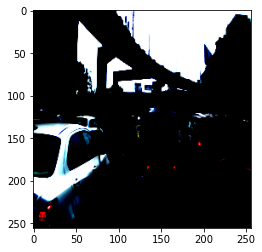

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


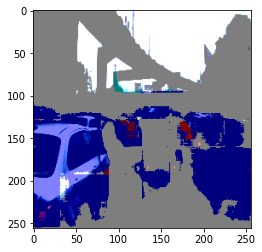

In [13]:
test()

In [8]:
torch.set_printoptions(precision=8)
intersection = torch.Tensor([3949, 3593, 3031, 5426, 5965,0])
intersection = torch.Tensor.float(intersection)
union = torch.Tensor([5789, 4460, 3842, 5864, 6331, 1303])
union = torch.Tensor.float(union)
iou = torch.Tensor.float(intersection/union).cuda()
#iou = torch.Tensor.float(torch.div(intersection.type(torch.LongTensor), union.type(torch.LongTensor)).cuda())
print((intersection).shape)
print(iou)
iou = iou[union!=0]
iou = torch.mean(iou)
print(iou)

torch.Size([6])
tensor([0.68215579, 0.80560535, 0.78891200, 0.92530698, 0.94218922, 0.00000000],
       device='cuda:0')
tensor(0.69069493, device='cuda:0')


In [ ]:
ious = [None]*25
print(len(ious))
print(ious)
ious[0] = [1,2,3]
print(ious)

In [ ]:
ious = np.asarray([[[1,3,0],[1,1,0],[2,1,1]],[[1,3,0],[1,1,0],[2,1,1]]])
abc = np.asarray([[[1,2,0],[1,2,1],[1,1,0]],[[1,3,0],[1,1,0],[2,1,1]]])
test = (ious[0][:]==abc[0][:])*(ious[1][:]==1)
print(test)
#ious.append([1,0,1])
#print(ious[:-1])
#ious = np.array(ious)
#print(np.mean(ious,axis=0))
#print(np.array(ious)[:][0:2])
# avg_iou = np.mean(np.array(ious[:][0:2])) #discarding class=26
# print(avg_iou)
# avg_iou = np.mean(avg_iou)
# print(avg_iou)

In [ ]:
print(str(labels[0].name))
#print()

In [ ]:
test_data = test_dataset[0]
print(len(test_data))
print(test_data[0].shape)
print("-------")
print(test_data[1].shape)
print(test_data[2].shape)

In [ ]:
a = [1]
print(np.mean(a[:-1]))

In [47]:
import numpy as np
a = torch.zeros(5).long().cuda()
b = torch.zeros(5).long().cuda()
nan_tensor = torch.Tensor([float('nan')]).long()
#torch.Tensor(np.full(pred.shape, cls)).long().cuda()
print(torch.div(b,a))
# print(a)
# print(b)
b[a==0]=#torch.tensor([float('nan')])
print(b)
# b[b!=b] = 5
# print(b)
print(torch.isnan(b))

tensor([4294967295, 4294967295, 4294967295, 4294967295, 4294967295],
       device='cuda:0')
tensor([-9223372036854775808, -9223372036854775808, -9223372036854775808,
        -9223372036854775808, -9223372036854775808], device='cuda:0')
tensor([False, False, False, False, False], device='cuda:0')


In [66]:
union = torch.zeros(5).long().cuda()
# union[1] = 1
# union[2] = 2
iou = torch.ones(5).long().cuda()
temp = iou[union!=0]
print("IOU = ",iou)
print("Union = ",union)
print("Temp = ",temp)
#result1 = torch.mean(torch.Tensor.float(temp))
result2 = (torch.sum(temp)/len(temp)).cpu().numpy()
print("Sum = ",torch.sum(temp))
print(np.nanmean(result2))
#print(len(temp)result2)

IOU =  tensor([1, 1, 1, 1, 1], device='cuda:0')
Union =  tensor([0, 0, 0, 0, 0], device='cuda:0')
Temp =  tensor([], device='cuda:0', dtype=torch.int64)
Sum =  tensor(0, device='cuda:0')
4294967295.0


In [53]:
union = torch.zeros(5).long().cuda()


TypeError: mean(): argument 'input' (position 1) must be Tensor, not list